# TD based A2C Model

In [2]:
from project.env_system import ManufacturingSystem
from gymnasium.wrappers import NormalizeReward 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import erlang

import pandas as pd

import random

# Use a double ended queue (deque) for memory
# When memory is full, this will replace the oldest value with the new one
from collections import deque

# for coping NN
import copy

import warnings
warnings.filterwarnings("ignore")

# Model parameters

In [3]:
#Discount rate of future rewards
GAMMA = 0.99
# Max number of games steps( state,action, reward, next state, action_prob) 
MEMORY_SIZE = 10_000_000
# Tot time step per episode
SIM_DURATION= 5000
# Sample batch size for policy Net update 
BATCH_SIZE = 5
# Number of game steps to play before starting training (all random actions)
REPLAY_START_SIZE = 50_000
# Number of steps between policy -> target net update 
SYNC_TARGET_STEPS = 1000
# Learning rate for NN
LEARNING_RATE = 0.003
# Training episodes
TRAINING_EPISODES = 1000 * SIM_DURATION
# test episodes
TEST_EPISODES = 100
# inter val episode we save the current checkpoint  of the training models
SAVE_CHECKPOINT = 300 * SIM_DURATION
# Save results
RESULTS_NAME = 'TD_based_a2c_4_step'
# path for save the training weights
check_p_path = 'weights/checkpoints/TD_based_a2c_4_step'
# path for save best net weights
best_path = 'weights/best/TD_based_a2c_4_step'
# if we are in a phase of restart the training
RESTART_TRAINGING = False




# SIM PARAMETERS
MAX_WIP= 80
ARRIVAL_TIME = 1/5.1
RANDOM_SEED= 42
EVAL_DAYS= 2500
WARMUP_PERIOD= 114
WIP_TOLERANCE= 7
DAYS_LOOKBACK= 10
N_TRACKERS= 33
SIM_TIME_STEP = 4
MIN_DUE_DATE = 77.00
MAX_DUE_DATE = 110
REWORK= 0.2
VERBOSE= False

# Actor-Critic Class

In [4]:
class Actor(nn.Module):
    """Actor Network"""
    def __init__(self, observation_space, action_space):
        """ set up the act net"""
        super().__init__()
        self.float()
        # neurons per hidden  layer 
        neurons_per_layer = observation_space
        self.device = 'cpu'
        self.net = nn.Sequential(
            nn.Linear(observation_space, neurons_per_layer).to(self.device),
            nn.ReLU().to(self.device),
            nn.Linear(neurons_per_layer, action_space).to(self.device) # we output the distribution over action space(before softmax)
        ).to(self.device)
    
    def act(self, state):
        """Act  and return action and action prob"""
        
        # convert to Tensor
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        
        probs = F.softmax(self.net(state), dim=-1)
        
        # Create a categorical distribution over actions
        action_dist = torch.distributions.Categorical(probs)
        
        # sample an action
        action = action_dist.sample().item()
        action_prob = probs[action].item()
        
        return action, action_prob
        
    def forward(self, x):
        """ Forward pass that return the logits before softmax """
        return self.net(x.to(self.device))

class Critic(nn.Module):
    """Critic Network"""
    def __init__(self, observation_space):
        """ set up the act net"""
        super().__init__()
        self.float()
        # neurons per hidden  layer 
        neurons_per_layer = observation_space
        self.device = 'cpu'
        self.net = nn.Sequential(
            nn.Linear(observation_space, neurons_per_layer).to(self.device),  
            nn.ReLU().to(self.device),                  
            nn.Linear(neurons_per_layer, 1).to(self.device)           # Output layer for state value
        ).to(self.device)
    
    def forward(self, x):
        """ Forward pass that return the state values of this state """

        return self.net(x.to(self.device))

# Policy net training function

In [5]:
def optimize(actor_net, critic_net, critic_target_net, memory):
    """
    Update  model by sampling from memory and return loss function ( value loss + policy loss).
    """
    
    # Do not try to train model if memory is less than required batch size
    if len(memory) < BATCH_SIZE:
        return 
    # sample a random batch from  memory
    batch = random.sample(memory, BATCH_SIZE)
    
    states, actions, rewards, states_next, action_probs = zip(*batch)
    
    # pre processing task
    states = torch.Tensor(states)
    actions = torch.LongTensor(actions).unsqueeze(-1) # [bs,] --> [bs, 1]
    states_next = torch.Tensor(states_next)
    rewards = torch.Tensor(rewards)
    behavior_action_probs = torch.Tensor(action_probs)
    
    # get action logits and state values
    action_logits = actor_net(states) # [bs, 2]
    s_values = critic_net(states) # [bs, 1]
    
    # for updating the value function like DQN with target net 
    next_state_values = critic_target_net(states_next).detach() # [bs, 1]
    target_values = (next_state_values * GAMMA) + rewards.unsqueeze(-1) # [bs, 1] 
    
    # for calculate the advantage using the current value net
    next_state_values_ = critic_net(states_next).detach() # [bs, 1]
    q_values = (next_state_values_ * GAMMA) + rewards.unsqueeze(-1) # [bs, 1]
    
    # calculate the critic function loss
    v_loss_f = nn.MSELoss()
    critic_loss = v_loss_f(s_values, target_values)
    
    # calculate the advantage and action probs
    advantage = (q_values - s_values.detach()).squeeze(-1) # [bs,]
    action_probs = F.softmax(action_logits, dim=-1).gather(1, actions).squeeze(-1) # [bs,]
    
    # calculate the importance ratio between actions probs of the past policy and the ones we sample with the new policy 
    impt_ratio = action_probs/(behavior_action_probs + 1e-6) 
    
    # calculate policy loss
    cel_f = nn.CrossEntropyLoss()
    actor_loss = advantage * impt_ratio.detach() *  cel_f(action_logits, actions.squeeze(-1))
    actor_loss = actor_loss.mean()
    
    # we sum together the loss
    loss = critic_loss + actor_loss
    
    # reset nets gradients
    critic_net.optimizer.zero_grad()
    actor_net.optimizer.zero_grad()
    
    # backpropagation loss
    loss.backward()
    
    # clamp the gradient in (-1,-1)
    for param in critic_net.parameters():
        param.grad.data.clamp_(-1, 1)
        
    for param in actor_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    # update net gradients 
    critic_net.optimizer.step()
    actor_net.optimizer.step()
    
    return loss.detach().item()

# Memory Class

In [6]:
class Memory():
    """
    Replay memory used to train model.
    Limited length memory (using deque, double ended queue from collections).
      - When memory full deque replaces oldest data with newest.
    Holds, state, action, reward, next state, and episode done.
    """
    def __init__(self):
        self.memory = deque(maxlen=MEMORY_SIZE)
    
    def remember(self, state, action, reward, next_state, action_prob):
        """
        Store the values
        """
        self.memory.append((state, action, reward, next_state, action_prob))

# Results Plotting function

In [7]:
def plot_results(loss, returns, wip, throughput, ea_ta_ti, lengths, agent_releases):
    """"Plot and report results at end of learning process"""

    # plot loss
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)


    lns1 = ax1.plot(
         loss, label='loss', color='g', linestyle=':')

    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('loss')
    plt.title('Loss Distribution')
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_loss.png'
    plt.savefig(filename, dpi=300)
    plt.show()

    # plot WIP
    plt.plot( wip,
             label='WIP', color='r')

    plt.xlabel('Episode')
    plt.ylabel('WIP in System')
    plt.title('WIP Distribution')
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_wip.png'
    plt.savefig(filename, dpi=300)
    plt.show()

    # plot agent releases
    plt.plot(agent_releases,
             label='agent_releases', color='r')

    plt.xlabel('Episode')
    plt.ylabel('Rate of release')
    plt.title('Agent Releases Distribution')
    filename = 'output/' + RESULTS_NAME + '/' + RESULTS_NAME + '_agent_releases.png'
    plt.savefig(filename, dpi=300)
    plt.show()

    # chart for throughput
     # Set up chart (ax1 and ax2 share x-axis to combine two plots on one graph)
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)


    lns2 = ax1.plot(throughput,
             label='Throughput', color='y')

    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('Throughput')
    plt.title('Monthly Throughput Distribution')
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_throughput.png'
    plt.savefig(filename, dpi=300)
    plt.show()


    # chart of discounted returns
    plt.plot(returns)
    plt.xlabel('Episode')
    plt.ylabel('Episode Return')
    plt.title('Mean Return')
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_returns.png'
    plt.savefig(filename, dpi=300)
    plt.show()


    # chart of lengths
    plt.plot(lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')
    plt.title('Episode Length Distribution')
    filename = 'output/' + RESULTS_NAME + '/' + RESULTS_NAME + 'e_length.png'
    plt.savefig(filename, dpi=300)
    plt.show()


    # Create a new figure for plotting the 3d scatter
    fig = plt.figure()

    # Extracting x, y, z coordinates from the data
    x = [point[0] for point in ea_ta_ti]
    y = [point[1] for point in ea_ta_ti]
    z = [point[2] for point in ea_ta_ti]


    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot in 3D
    ax.scatter(x, y, z)

    # Create a colormap
    gradient = np.linspace(0, 1, len(ea_ta_ti))

    cool = plt.colormaps['cool']

    # Create a scatter plot in 3D with a color gradient
    sc = ax.scatter(x, y, z, c=gradient, cmap=cool)

    # Highlight the first point
    ax.scatter(x[0], y[0], z[0], color='red', s=100, label='First run')
    ax.text(x[0], y[0], z[0], 'First', color='red')

    # Highlight the last point
    ax.scatter(x[-1], y[-1], z[-1], color='green', s=100, label='Last run')
    ax.text(x[-1], y[-1], z[-1], 'Last', color='green')



    # Customize the tick labels
    # Set color gradient legend with only first and last ticks
    cbar = plt.colorbar(sc, ax=ax, ticks=[0, 1], orientation='vertical', pad=0.1)
    cbar.set_label('Runs')
    cbar.ax.set_yticklabels([1, len(ea_ta_ti)])

    # Labeling the axes
    ax.set_xlabel('EA')
    ax.set_ylabel('TA')
    ax.set_zlabel('TI')

    # Set a title for the plot
    ax.set_title('Job dones distribution')
    ax.legend()
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_scatter.png'
    plt.savefig(filename, dpi=300)

    # Show the plot
    plt.show()

# Main Progam

In [8]:
def a2c_company():
    """Main program loop"""
    ############################################################################
    #                          1 Set up Gym+SimPy environment                  #
    ############################################################################
    sim = ManufacturingSystem(
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=ARRIVAL_TIME), 
        service_time_distribution=lambda x,y: erlang.rvs(5,loc=(x - 5 *(y/5)**(1/2)),scale=(y/5)**(1/2)),
        rework_distribution=lambda: random.random() <= REWORK,
        due_dates_distribution=lambda : random.uniform(a=MIN_DUE_DATE, b=MAX_DUE_DATE),
        warmup_period=WARMUP_PERIOD,
        max_wip=MAX_WIP,
        sim_duration=SIM_DURATION,
        random_seed=RANDOM_SEED,
        eval_days=EVAL_DAYS,
        wip_tol=WIP_TOLERANCE,
        days_lookback=DAYS_LOOKBACK,
        n_trackers=N_TRACKERS,
        verbose=VERBOSE,
        sim_time_step=SIM_TIME_STEP
    )
    
    # normalize the rewards 
    sim = NormalizeReward(sim)
    
    # get number of obs returned for state
    obs_space = sim.observation_size
    
    # number of actions possible ( boolean)
    action_space = sim.action_size
    
    ############################################################################
    #                    2 Set up policy and target nets                       #
    ############################################################################
    
    # set up and keep best net performance
    actor_net = Actor(obs_space, action_space)
    critic_net = Critic(obs_space)
    critic_target_net = copy.deepcopy(critic_net)
    
    # policy_net = A2C(obs_space, action_space)
    # target_net = copy.deepcopy(policy_net)
    best_net = copy.deepcopy(actor_net)
    
    # Set optimizer
    actor_net.optimizer = optim.Adam(
        params=actor_net.parameters(), lr=LEARNING_RATE
    )
    
    critic_net.optimizer = optim.Adam(
        params=critic_net.parameters(), lr=LEARNING_RATE
    )
    
    # copy weights from policy net to target
    critic_target_net.load_state_dict(critic_net.state_dict())
    
    # Set target net to eval for not training it 
    critic_target_net.eval()
    
    ############################################################################
    #                           3 Set up memory                                #
    ############################################################################
    
    memory = Memory()
    
    ############################################################################
    #                     4 Set up + start training loop                      #
    ############################################################################
    
    # set up run counter and learning loop
    all_steps = 0
    continue_learning = True
    best_reward = -np.inf

    # check if we've to restart the training
    if RESTART_TRAINGING:
        # load the state dicts and run counter
        checkpoint = torch.load(check_p_path)
        actor_net.load_state_dict(checkpoint['actor_state_dict'])
        critic_net.load_state_dict(checkpoint['critic_state_dict'])
        critic_target_net.load_state_dict(checkpoint['critic_target_state_dict'])
        best_net.load_state_dict(checkpoint['best_state_dict'])
        critic_net.optimizer.load_state_dict(checkpoint['critic_opt_state_dict'])
        actor_net.optimizer.load_state_dict(checkpoint['actor_opt_state_dict'])
        all_steps = checkpoint['epoch']
    
    # set up list for results
    results_losses = []
    results_returns = []
    results_mean_wip = []
    results_mean_throughput = []
    results_ea_ta_ti = []
    results_length = []
    results_agent_releases = []
    results_psp_length = []


    
    # Continue repeating episodes until target complete
    while continue_learning:
        # play episode

        
        # reset env 
        state = sim.reset()
        
        # reset lists ( we remember the last all steps counter for compute the length of the episode)
        prev_all_steps = all_steps
        all_steps += WARMUP_PERIOD
        tot_reward = 0
        e_loss = 0
        rewards = []
        
        
        # continue loop until episode complete or truncated
        while True:
            # get action to take ( set eval mode to avoid dropout layers)
            actor_net.eval()
            action, a_prob = actor_net.act(state)
            
            # play action ( get S', R, T, TR)
    
            # Act 
            state_next, reward, terminal, truncated, info = sim.step(action)
            
            tot_reward += reward
            
            # update trackers
            all_steps += SIM_TIME_STEP
            rewards.append(reward)
            
            if not truncated:
                # record the state, action, reward, next state and action prob
                memory.remember(state, action,reward, state_next, a_prob)
            
            # update state 
            state = state_next
            
            # check if end of episode
            if terminal and not truncated:
                # Clear print row content 
                clear_row = '\r' + ' ' * 500 + '\r'
                print(clear_row, end='')
                process = (all_steps / TRAINING_EPISODES) * 100
                # we block when we reach the finish
                process = min(100, process)
                print(f'Training Progress: {process:4.1f}%, ', end='')
                length = all_steps - prev_all_steps
                print(f'Episode length: {length}, ', end='')
                print(f'Loss: {e_loss: .3f}, ', end='')
                avg_wip = np.mean(info['wip in system'])
                print(f'Average Tot WIP: {avg_wip:4.1f}, ', end='')
                throughput = 30 *(info['number of job dones'] / SIM_DURATION)
                print(f'Throughput: {throughput:4.1f}, ', end='')
                last_ea_ta_ti = info['EA_TA_TI'][-1]
                # trasform in np array
                last_ea_ta_ti = np.array(last_ea_ta_ti)
                last_ea_ta_ti = (last_ea_ta_ti /info['number of job dones']) * 100
                print(f'EA: {last_ea_ta_ti[0]:4.1f}%, ', end='')
                print(f'TA: {last_ea_ta_ti[1]:4.1f}%, ', end='')
                print(f'TI: {last_ea_ta_ti[2]:4.1f}%, ', end='')
                jobs_create = info['number of job create']
                print(f'jobs create: {jobs_create}, ', end='')
                rate_agent_release = info['Agent releases']
                print(f'Rate of agent release: {rate_agent_release:4.1f}%, ', end='')
                psp_length = info['psp_list']
                print(f'PSP Length: {psp_length:4.1f}', end='')
                
                # add to  results lists
                results_length.append(length)
                results_losses.append(e_loss)
                results_returns.append(tot_reward)
                results_mean_wip.append(avg_wip)
                results_mean_throughput.append(throughput)
                results_ea_ta_ti.append(last_ea_ta_ti)
                results_agent_releases.append(rate_agent_release)
                results_psp_length.append(psp_length)
                
                
                if tot_reward > best_reward:
                    best_reward = tot_reward
                    # copy weights 
                    best_net.load_state_dict(actor_net.state_dict())
                
                # check for end  of learning 
                if all_steps >= TRAINING_EPISODES:
                    continue_learning = False
                
                # end episode loop
                break
            
            # check if truncated episode
            if truncated:

                # Clear print row content
                clear_row = '\r' + ' ' * 500 + '\r'
                print(clear_row, end='')
                process = (all_steps / TRAINING_EPISODES) * 100
                # we block when we reach the finish
                process = min(100, process)
                print(f'Training Progress: {process:4.1f}%, ', end='')
                length = all_steps - prev_all_steps
                print(f'Episode length: {length}, ', end='')
                print(f'Loss: {e_loss: .3f}, ', end='')
                avg_wip = np.mean(info['wip in system'])
                print(f'Average Tot WIP: {avg_wip:4.1f}, ', end='')
                throughput = 30 *(info['number of job dones'] / SIM_DURATION)
                print(f'Throughput: {throughput:4.1f}, ', end='')
                last_ea_ta_ti = info['EA_TA_TI'][-1]
                # trasform in np array
                last_ea_ta_ti = np.array(last_ea_ta_ti)
                last_ea_ta_ti = (last_ea_ta_ti /info['number of job dones']) * 100
                print(f'EA: {last_ea_ta_ti[0]:4.1f}%, ', end='')
                print(f'TA: {last_ea_ta_ti[1]:4.1f}%, ', end='')
                print(f'TI: {last_ea_ta_ti[2]:4.1f}%, ', end='')
                jobs_create = info['number of job create']
                print(f'jobs create: {jobs_create}, ', end='')
                rate_agent_release = info['Agent releases']
                print(f'Rate of agent release: {rate_agent_release:4.1f}%, ', end='')
                psp_length = info['psp_list']
                print(f'PSP Length: {psp_length:4.1f} ', end='')

                # add to  results lists
                results_length.append(length)
                results_losses.append(e_loss)
                results_returns.append(tot_reward)
                results_mean_wip.append(avg_wip)
                results_mean_throughput.append(throughput)
                results_ea_ta_ti.append(last_ea_ta_ti)
                results_agent_releases.append(rate_agent_release)
                results_psp_length.append(psp_length)
                
                # check for end  of learning 
                if all_steps >= TRAINING_EPISODES:
                    continue_learning = False
                
                # end episode loop
                break

            # update policy net
            
            # avoid training model if memory is not sufficient 
            if len(memory.memory) > REPLAY_START_SIZE:
                
                # update policy net and calculate loss function  
                loss = optimize(actor_net, critic_net, critic_target_net, memory.memory)
                
                if loss is not None:
                    e_loss += loss
                
                # update target net periodically
                # Use load_state_dict method to copy weights from critic policy net
                if all_steps % SYNC_TARGET_STEPS == 0:
                    critic_target_net.load_state_dict(critic_net.state_dict())

            # check if we've to save the model
            if all_steps % SAVE_CHECKPOINT == 0:
                torch.save({
                    'epoch': all_steps,
                    'actor_state_dict': actor_net.state_dict(),
                    'critic_target_state_dict': critic_net.state_dict(),
                    'target_state_dict': critic_target_net.state_dict(),
                    'best_state_dict': best_net.state_dict(),
                    'actor_opt_state_dict': actor_net.optimizer.state_dict(),
                    'critic_opt_state_dict': critic_net.optimizer.state_dict()
                }, check_p_path)
                # and save the result
                run_details = pd.DataFrame()
                run_details['Episode Length'] = results_length
                run_details['loss'] = results_losses
                run_details['Returns'] = results_returns
                run_details['mean wip'] = results_mean_wip
                run_details['monthly mean throughput'] = results_mean_throughput
                run_details['Agent releases'] = results_agent_releases
                run_details['PSP length'] = results_psp_length

                # convert in np array
                ea_ta_ti = np.array(results_ea_ta_ti)
                run_details['EA %'] = ea_ta_ti[:, 0]
                run_details['TA %'] = ea_ta_ti[:, 1]
                run_details['TI %'] = ea_ta_ti[:, 2]


                filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_train_result.csv'
                run_details.to_csv(filename, index=True, index_label='run')
        
    

    ############################################################################
    #             5 Learning complete - plot and save results                 #
    ############################################################################
    plot_results(results_losses, results_returns, results_mean_wip, results_mean_throughput,results_ea_ta_ti, results_length,results_agent_releases)
    
    # save results 
    run_details = pd.DataFrame()
    run_details['Episode Length'] = results_length
    run_details['loss'] = results_losses
    run_details['Returns'] = results_returns
    run_details['mean wip'] = results_mean_wip
    run_details['monthly mean throughput'] = results_mean_throughput
    run_details['Agent releases'] = results_agent_releases
    run_details['PSP length'] = results_psp_length
    
    # convert in np array
    ea_ta_ti = np.array(results_ea_ta_ti)
    run_details['EA %'] = ea_ta_ti[:, 0]
    run_details['TA %'] = ea_ta_ti[:, 1]
    run_details['TI %'] = ea_ta_ti[:, 2]

    
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_train_result.csv'
    run_details.to_csv(filename, index=True, index_label='run')

    # save best net weights
    torch.save({
        'best_state_dict': best_net.state_dict()
    },best_path)
    
    ############################################################################
    #                             Test best model                              #
    ############################################################################
    
    print()
    print('Test Model')
    print('----------')
    
    best_net.eval()
    
    # set results dict 
    results = dict()
    results['wip'] = []
    results['returns'] = []
    results['monthly throughput'] = []
    results['EA'] = []
    results['TA'] = []
    results['TI'] = []
    results['Agent releases'] = []
    results['PSP length'] = []
    
    
    # Replicate model runs
    for run in range(TEST_EPISODES):
        # reset env 
        state = sim.reset()
        # set returns
        tot_reward = 0
        
        # continue loop until episode complete
        while True:
            # get action to take 
            best_net.eval()
            action,_ = best_net.act(state)
            
            # Act
            state_next, reward, terminal, truncated, info = sim.step(action)

            # update state and reward
            tot_reward += reward
            # update state
            state = state_next
            
            if terminal:
                print(f'Run: {run}, ', end='')
                avg_wip = np.mean(info['wip in system'])
                print(f'Average Tot WIP: {avg_wip:4.1f}, ', end='')
                print(f'Tot reward: {tot_reward}, ', end='')
                throughput = 30 *(info['number of job dones'] / SIM_DURATION)
                print(f'Throughput: {throughput:4.1f}, ', end='')
                last_ea_ta_ti = info['EA_TA_TI'][-1]
                last_ea_ta_ti = np.array(last_ea_ta_ti)
                last_ea_ta_ti = (last_ea_ta_ti /info['number of job dones']) * 100
                print(f'EA: {last_ea_ta_ti[0]:4.1f}%, ', end='')
                print(f'TA: {last_ea_ta_ti[1]:4.1f}%, ', end='')
                print(f'TI: {last_ea_ta_ti[2]:4.1f}%,  ', end='')
                rate_agent_release = info['Agent releases']
                print(f'Rate of agent release: {rate_agent_release:4.1f}% ', end='')
                psp_length = info['psp_list']
                print(f'PSP Length: {psp_length:4.1f} ', end='')
                print()
                # add to results

                results['wip'].append(avg_wip)
                results['returns'].append(tot_reward)
                results['monthly throughput'].append(throughput)
                results['EA'].append(last_ea_ta_ti[0])
                results['TA'].append(last_ea_ta_ti[1])
                results['TI'].append(last_ea_ta_ti[2])
                results['Agent releases'].append(rate_agent_release)
                results['PSP length'].append(psp_length)
                
                # End episode loop
                break
    
    results = pd.DataFrame(results)
    filename = 'output/' + RESULTS_NAME +'/' + RESULTS_NAME + '_test_result.csv'
    results.to_csv(filename, index=True, index_label='run')
    print()
    print(results.describe())
            
    return run_details

#  Model Entry Point

Training Progress: 100.0%, Episode length: 2978, Loss: -310066.202, Average Tot WIP: 63.1, Throughput:  3.4, EA: 77.7%, TA: 19.9%, TI:  2.4%, jobs create: 610, Rate of agent release: 81.0%, PSP Length:  4.0                                                                                                                                                                                                                                                                                                      

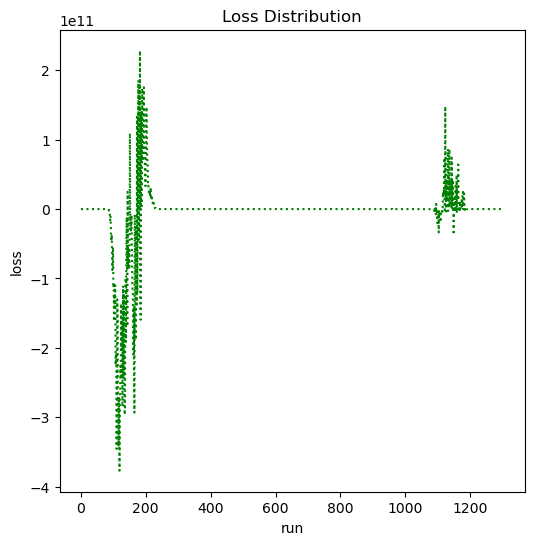

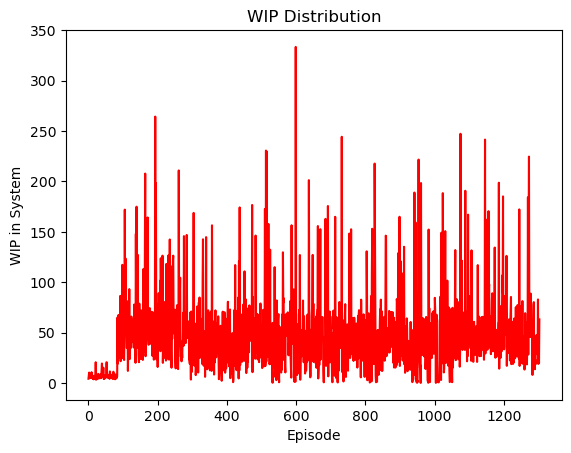

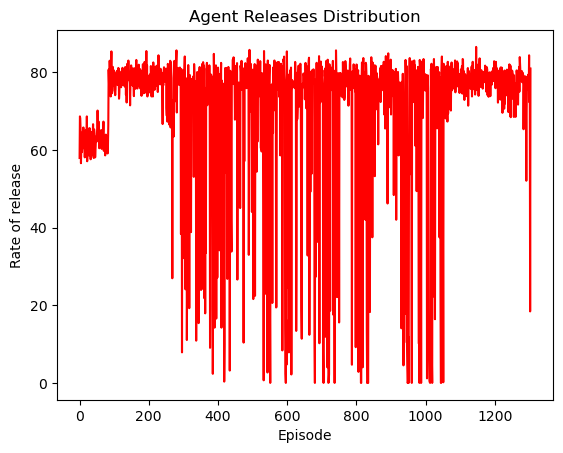

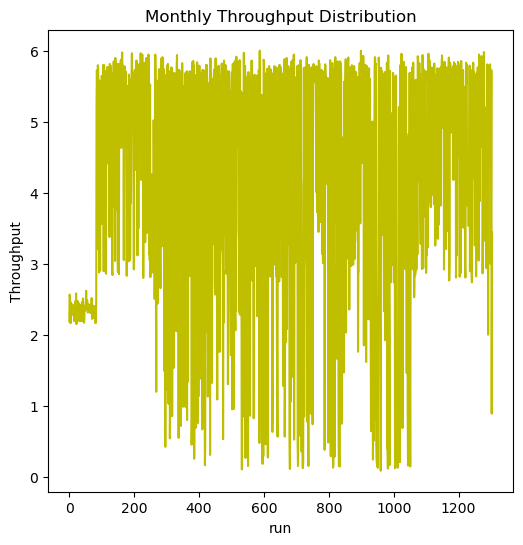

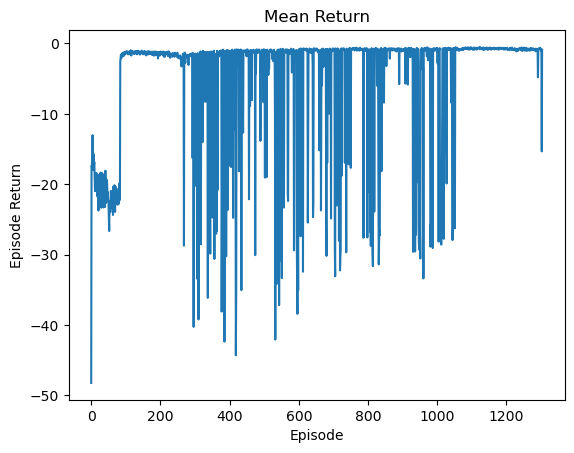

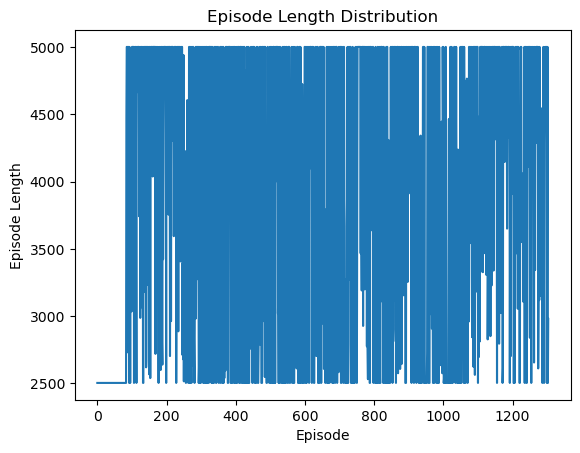

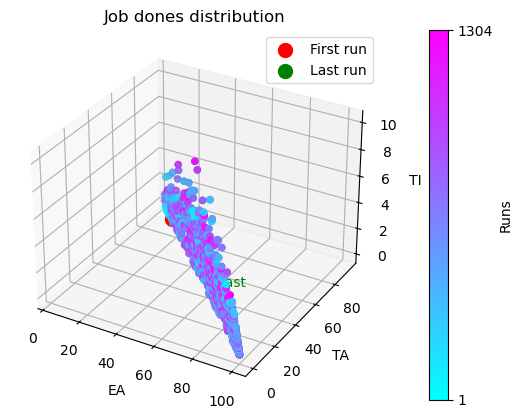


Test Model
----------
Run: 0, Average Tot WIP: 153.8, Tot reward: -0.7741141117639395, Throughput:  5.8, EA: 27.1%, TA: 72.8%, TI:  0.1%,  Rate of agent release: 79.2% PSP Length:  0.0 
Run: 1, Average Tot WIP: 54.4, Tot reward: -100.25961777735289, Throughput:  5.7, EA: 64.9%, TA: 32.0%, TI:  3.0%,  Rate of agent release: 76.5% PSP Length:  2.0 
Run: 2, Average Tot WIP: 86.5, Tot reward: -25.978903675021087, Throughput:  5.6, EA: 37.9%, TA: 58.2%, TI:  3.8%,  Rate of agent release: 76.2% PSP Length:  1.0 
Run: 3, Average Tot WIP: 51.0, Tot reward: -22.02581112148187, Throughput:  5.7, EA: 70.0%, TA: 27.1%, TI:  2.8%,  Rate of agent release: 76.1% PSP Length:  0.0 
Run: 4, Average Tot WIP: 119.6, Tot reward: -0.7310394250816825, Throughput:  5.9, EA: 26.9%, TA: 70.8%, TI:  2.3%,  Rate of agent release: 78.5% PSP Length:  1.0 
Run: 5, Average Tot WIP: 86.7, Tot reward: -4.589283111900187, Throughput:  5.9, EA: 36.7%, TA: 62.1%, TI:  1.2%,  Rate of agent release: 79.5% PSP Length:  1.0 

Run: 50, Average Tot WIP: 51.4, Tot reward: -1.1927719803612487, Throughput:  5.8, EA: 73.9%, TA: 24.7%, TI:  1.3%,  Rate of agent release: 79.7% PSP Length:  1.0 
Run: 51, Average Tot WIP: 45.9, Tot reward: -0.5973495964454358, Throughput:  5.9, EA: 85.3%, TA: 13.5%, TI:  1.2%,  Rate of agent release: 80.7% PSP Length:  2.0 
Run: 52, Average Tot WIP: 29.4, Tot reward: -0.458082288264834, Throughput:  5.5, EA: 93.6%, TA:  3.9%, TI:  2.5%,  Rate of agent release: 73.6% PSP Length:  0.0 
Run: 53, Average Tot WIP: 34.7, Tot reward: -0.5424258149846171, Throughput:  5.6, EA: 83.8%, TA: 13.8%, TI:  2.3%,  Rate of agent release: 75.0% PSP Length:  1.0 
Run: 54, Average Tot WIP: 89.2, Tot reward: -29.849315377119876, Throughput:  5.9, EA: 32.7%, TA: 65.7%, TI:  1.6%,  Rate of agent release: 79.5% PSP Length:  2.0 
Run: 55, Average Tot WIP: 37.8, Tot reward: -0.6566507506946199, Throughput:  6.0, EA: 92.8%, TA:  5.4%, TI:  1.7%,  Rate of agent release: 80.3% PSP Length:  3.0 
Run: 56, Average 

In [9]:
last_run = a2c_company()
